### Modelling relational inference

As in Whittington et al. (2020), we model the spatial task of predicting the next location in a trajectory as the prediction of the next node in a graph. We create a large set of graphs, each one an n-by-n grid of nodes representing a simple spatial environment. Nodes are labelled with random letters to represent arbitrary associations at a particular location. Each directed edge, i.e. each possible transition in the graph, is of the type north, south, east, or west. Random walks in the set of graphs are used to train the model; these could represent sequences stored in an initial bank of memories. The generative model is trained from scratch on the replayed sequences (converted to strings of the form ‘node1 E node2 W node3 …’) with the mechanism of causal language modelling.

Tested with conda_pytorch_latest_p36 kernel in AWS SageMaker.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Installation:

In [ ]:
!pip install simpletransformers csrgraph networkx==2.8 evaluate accelerate

In [ ]:
!wandb disabled

#### Imports:

In [ ]:
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import csrgraph as cg
import numpy as np
import random
import string
from graph_utils import *
from tree_utils import *
from gpt import GPT
import networkx as nx
import matplotlib.pyplot as plt
import random
import string
from itertools import combinations
import networkx as nx
import random
import pickle
import gc

In [ ]:
from simpletransformers.language_modeling import (
    LanguageModelingModel,
    LanguageModelingArgs,
)
from transformers import GPT2LMHeadModel, GPT2Tokenizer

class GPT:

    def __init__(self, base_model=None, base_model_name='gpt2', vocab_size=100):
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.vocab_size = vocab_size

        if self.base_model is not None:
            self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
            self.model = GPT2LMHeadModel.from_pretrained(base_model)
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def continue_input(self, input_sequence, max_new_tokens=5, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')

        # Generate text
        output = self.model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text

In [ ]:
def load_pkl(pth):
    with open(pth, 'rb') as f:
        d = pickle.load(f)
    return d

def is_valid_path(sequence, graphs):
    # Split the sequence into parts
    parts = sequence.split()

    # Extract nodes and edges; nodes are at even indices, edges at odd indices
    nodes = parts[::2]
    edges = parts[1::2]

    # Convert edges to a lowercase version for comparison (assuming all edges in graphs are lowercase)
    edges = [edge.lower() for edge in edges]

    # Iterate over each graph to check if the path exists
    for graph in graphs:
        path_exists = True
        for i in range(len(nodes) - 1):
            # Check if the current graph has the edge between the current node and the next node
            if not graph.has_edge(nodes[i], nodes[i+1]):
                path_exists = False
                break

        # If path exists in the current graph, return True
        if path_exists:
            return True

    # If none of the graphs contain the path, return False
    return False

In [ ]:
# TEST MEMORY / INFERENCE
# generate sequences of length l starting with one of the train nodes
# see if the sequences are valid in any of the train graphs

def test_memory(model, train_seqs, train_gs, steps_to_prompt=3, steps_to_test=5):
    results = []
    for sequence in train_seqs:
        first_item = ' '.join(sequence.split()[0:steps_to_prompt])
        print("Input to model:", first_item)
        out = model.continue_input(first_item, do_sample=False, num_beams=3, max_length=200)
        out = ' '.join(out.split()[0:steps_to_test])
        print("Output of model:", out)
        valid_path = is_valid_path(out, train_gs)
        print("Valid path in any graph:", valid_path)
        results.append(valid_path)

    return results.count(True) / len(results)

In [ ]:
def train_model_script(num_epochs=3,
                       output_dir='outputs',
                       lr=5e-05):
    gc.collect()
    train_path = f'./{output_dir}/train.txt'
    ! python ./run_clm_from_scratch.py \
        --model_type 'gpt2-medium' \
        --tokenizer_name 'gpt2' \
        --train_file {train_path} \
        --validation_file {train_path} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'epoch' \
        --learning_rate {lr}

### Spatial graph

In [ ]:
!rm -rf outputs_graph
!mkdir outputs_graph

text_file = open("outputs_graph/train.txt", "w")
walks, train_gs = get_walks_as_strings(n_graphs=100000, n_walks=1, walk_length=50)
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

text_file = open("outputs_graph/test.txt", "w")
walks, test_gs = get_walks_as_strings(n_graphs=20, n_walks=1, walk_length=50)
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

train_model_script(num_epochs=5,
                   output_dir='outputs_graph',
                   lr=1e-05)


In [ ]:
with open(f'outputs_graph/train_graphs.pkl', 'wb') as handle:
      pickle.dump(train_gs, handle)
with open(f'outputs_graph/test_graphs.pkl', 'wb') as handle:
      pickle.dump(test_gs, handle)

In [ ]:
!rm -rf outputs_graph/checkpoint*
!mkdir drive/MyDrive/colab_code/graphmodels/spatialgraph2/
!cp -r outputs_graph/* drive/MyDrive/colab_code/graphmodels/spatialgraph2/

### Family tree graph

In [ ]:
!rm -rf outputs_tree
!mkdir outputs_tree

text_file = open("outputs_tree/train.txt", "w")
walks, train_gs = get_walks_for_n_trees(n_graphs=100000, n_walks=1, walk_length=50)
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

text_file = open("outputs_tree/test.txt", "w")
walks, test_gs = get_walks_for_n_trees(n_graphs=20, n_walks=1, walk_length=50)
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

train_model_script(num_epochs=5,
                   output_dir='outputs_tree',
                   lr=5e-05)


In [ ]:
with open(f'outputs_tree/train_trees.pkl', 'wb') as handle:
      pickle.dump(train_gs, handle)
with open(f'outputs_tree/test_trees.pkl', 'wb') as handle:
      pickle.dump(test_gs, handle)

In [ ]:
!rm -rf outputs_tree/checkpoint*
!mkdir drive/MyDrive/colab_code/graphmodels/familygraph2/
!cp -r outputs_tree/* drive/MyDrive/colab_code/graphmodels/familygraph2/

### Test trained models

#### Test tree model

In [ ]:
train_gs = load_pkl('outputs_tree/train_trees.pkl')
test_gs = load_pkl('outputs_tree/test_trees.pkl')

model = GPT(base_model='outputs_tree', base_model_name='gpt2')

with open('outputs_tree/test.txt', 'r') as file:
    test_seqs = file.readlines()

inference_score = test_memory(model, test_seqs, test_gs, steps_to_prompt=5, steps_to_test=10)

print("Inference score:", inference_score)

#### Test graph model

In [ ]:
train_gs = load_pkl('outputs_graph/train_graphs.pkl')
test_gs = load_pkl('outputs_graph/test_graphs.pkl')

model = GPT(base_model='outputs_graph', base_model_name='gpt2')

with open('outputs_graph/test.txt', 'r') as file:
    test_seqs = file.readlines()

inference_score = test_memory(model, test_seqs, test_gs, steps_to_prompt=5, steps_to_test=10)

print("Inference score:", inference_score)

#### Test loop inferences

In [ ]:
import random
import string

def generate_name() -> str:
    """Generate a random 2-letter name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def test_loop(model, loop_templates):
    accuracy_scores = []  # Store accuracy scores for each template
    results_dict = {}

    for template in loop_templates:
        template_accuracy = []  # Store accuracy for each iteration of the current template

        for _ in range(100):  # Repeat for 10 versions of each template
            # Fill the template with random names
            names = [generate_name() for _ in range(template.count("{}") - 1)]
            names += [names[0]]
            filled_template = template.format(*names)
            print(filled_template)

            # The true final item is the last name generated
            true_final_item = names[-1]
            input_len = len(filled_template.split())

            # Use the model to predict/continue the input based on the filled template
            # Adjust the prompt as needed for your specific model and task
            prediction = model.continue_input(filled_template[0:-3],
                                              max_new_tokens=5,
                                              num_beams=5)
            print(prediction)
            # Assuming the prediction is a string, extract the last word/item
            predicted_items = prediction.strip().split()[0:input_len]
            predicted_final_item = predicted_items[-1] if predicted_items else None
            print(f"True final:{true_final_item}, predicted final: {predicted_final_item}")

            # Calculate accuracy for this iteration
            is_correct = int(predicted_final_item == true_final_item)
            print(is_correct)
            template_accuracy.append(is_correct)

        # Calculate average accuracy for this template
        accuracy_scores.extend(template_accuracy)
        results_dict[template] = sum(template_accuracy) / len(template_accuracy)

    # Calculate and return the overall average accuracy
    overall_avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    return overall_avg_accuracy, results_dict


In [ ]:
loop_templates = ["{} EAST {} WEST {}",
                  "{} WEST {} EAST {}",
                  "{} NORTH {} SOUTH {}",
                  "{} SOUTH {} NORTH {}",
                  "{} EAST {} SOUTH {} WEST {} NORTH {}",
                  "{} SOUTH {} WEST {} NORTH {} EAST {}",
                  "{} WEST {} NORTH {} EAST {} SOUTH {}",
                  "{} NORTH {} EAST {} SOUTH {} WEST {}",
                  "{} EAST {} EAST {} NORTH {} WEST {} WEST {} SOUTH {}",
                  "{} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} EAST {}"]

# Run the test
model = GPT(base_model='outputs_graph', base_model_name='gpt2')
average_accuracy, spatial_results_dict = test_loop(model, loop_templates)
print(f"Average Accuracy: {average_accuracy}")

To regenerate results in thesis:

In [1]:
# spatial_results_dict = {'{} EAST {} WEST {}': 0.87,
#  '{} WEST {} EAST {}': 0.82,
#  '{} NORTH {} SOUTH {}': 0.81,
#  '{} SOUTH {} NORTH {}': 0.87,
#  '{} EAST {} SOUTH {} WEST {} NORTH {}': 0.71,
#  '{} SOUTH {} WEST {} NORTH {} EAST {}': 0.78,
#  '{} WEST {} NORTH {} EAST {} SOUTH {}': 0.8,
#  '{} NORTH {} EAST {} SOUTH {} WEST {}': 0.81,
#  '{} EAST {} EAST {} NORTH {} WEST {} WEST {} SOUTH {}': 0.79,
#  '{} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} EAST {}': 0.74}

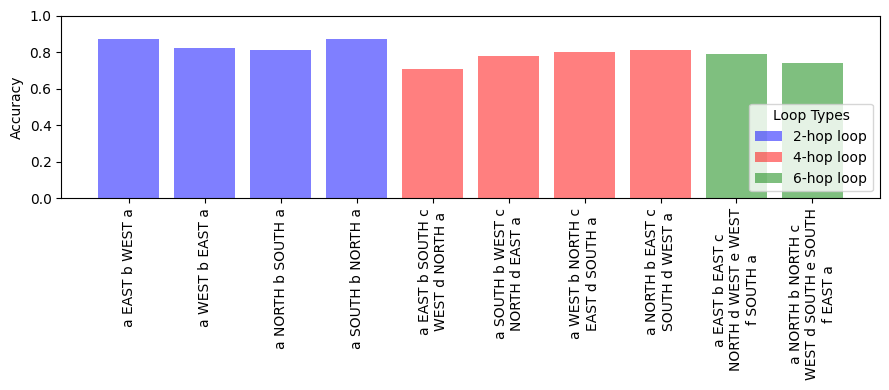

In [2]:
import matplotlib.pyplot as plt
import textwrap

def format_sequence(s):
    """Format the sequence with alphabets."""
    placeholders = s.count("{}")
    replacements = [chr(97 + i) for i in range(placeholders - 1)] + ['a']  # ['a', 'b', ..., 'a']
    formatted = s.format(*replacements)
    return formatted

def wrap_labels(labels, width=25):
    """Wrap labels to multiple lines."""
    return [textwrap.fill(label, width) for label in labels]

def get_hops_count(key):
    """Get the number of hops based on the number of underscores."""
    return int(len(key.split()) - 1 ) // 2

accuracy_dict = spatial_results_dict

colors = ['black', 'green', 'blue', 'cyan', 'red', 'magenta', 'green', 'black']

# Step 1: Sort the dictionary by the length of the keys
sorted_items = sorted(accuracy_dict.items(), key=lambda x: len(x[0]))

# Step 2: Prepare data for plotting
keys = [format_sequence(k) for k, v in sorted_items]
wrapped_keys = wrap_labels(keys, width=20)
accuracies = [v for k, v in sorted_items]
hops_counts = [get_hops_count(k) for k, v in sorted_items]
bar_colors = [colors[count % len(colors)] for count in hops_counts]  # Use modulo to cycle through colors if necessary

# Step 3: Plotting
plt.figure(figsize=(9, 4))
for i in range(len(wrapped_keys)):
    plt.bar(i, accuracies[i],
            color=bar_colors[i],
            label=f'{hops_counts[i]}-hop loop' if i == 0 or hops_counts[i] != hops_counts[i-1] else "",
           alpha=0.5)

plt.xticks(range(len(wrapped_keys)), wrapped_keys, rotation=90, ha="center", fontsize=10)
#plt.xlabel('Sequences')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.tight_layout()

# Create legend without duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Loop Types", loc='lower right')

plt.savefig('loops_spatial.png', dpi=300)
plt.show()


In [ ]:
# Example loop templates
loop_templates = ["{} CHILD_OF {} PARENT_OF {}",
                  "{} PARENT_OF {} CHILD_OF {}",
                  "{} GRANDCHILD_OF {} GRANDPARENT_OF {}",
                  "{} GRANDPARENT_OF {} GRANDCHILD_OF {}",
                  "{} CHILD_OF {} CHILD_OF {} GRANDPARENT_OF {} SIBLING_OF {}",
                  "{} CHILD_OF {} SPOUSE_OF {} PARENT_OF {} SIBLING_OF {}",
                  "{} PARENT_OF {} SIBLING_OF {} CHILD_OF {} SPOUSE_OF {}",
                  "{} PARENT_OF {} PARENT_OF {} GRANDCHILD_OF {} SPOUSE_OF {}",
                  "{} CHILD_OF {} SPOUSE_OF {} CHILD_OF {} SPOUSE_OF {} GRANDPARENT_OF {} SIBLING_OF {}",
                  "{} GRANDPARENT_OF {} SIBLING_OF {} CHILD_OF {} SPOUSE_OF {} CHILD_OF {} SPOUSE_OF {}"
                 ]

# Run the test
model = GPT(base_model='oututs_tree', base_model_name='gpt2')
average_accuracy, family_results_dict = test_loop(model, loop_templates)
print(f"Average Accuracy: {average_accuracy}")

To regenerate results in thesis:

In [3]:
# family_results_dict = {'{} CHILD_OF {} PARENT_OF {}': 0.81,
#  '{} PARENT_OF {} CHILD_OF {}': 0.76,
#  '{} GRANDCHILD_OF {} GRANDPARENT_OF {}': 0.8,
#  '{} GRANDPARENT_OF {} GRANDCHILD_OF {}': 0.62,
#  '{} CHILD_OF {} CHILD_OF {} GRANDPARENT_OF {} SIBLING_OF {}': 0.7,
#  '{} CHILD_OF {} SPOUSE_OF {} PARENT_OF {} SIBLING_OF {}': 0.75,
#  '{} PARENT_OF {} SIBLING_OF {} CHILD_OF {} SPOUSE_OF {}': 0.79,
#  '{} PARENT_OF {} PARENT_OF {} GRANDCHILD_OF {} SPOUSE_OF {}': 0.77,
#  '{} CHILD_OF {} SPOUSE_OF {} CHILD_OF {} SPOUSE_OF {} GRANDPARENT_OF {} SIBLING_OF {}': 0.75,
#  '{} GRANDPARENT_OF {} SIBLING_OF {} CHILD_OF {} SPOUSE_OF {} CHILD_OF {} SPOUSE_OF {}': 0.72}

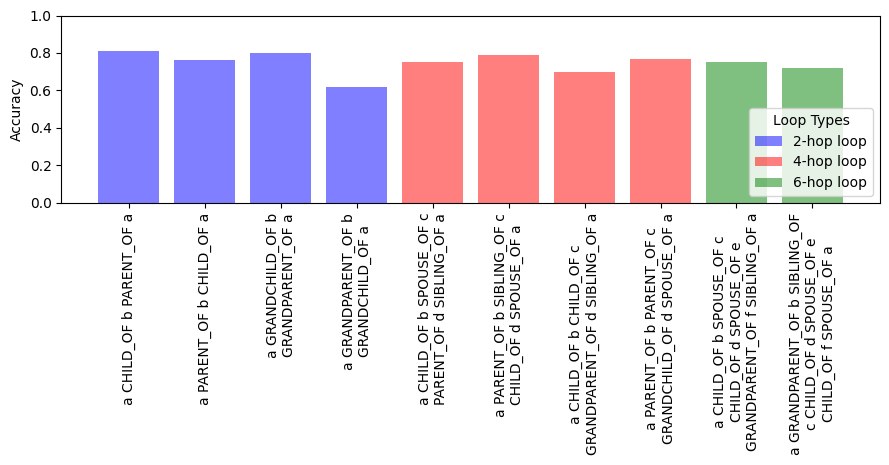

In [5]:
import matplotlib.pyplot as plt
import textwrap

def format_sequence(s):
    """Format the sequence with alphabets."""
    placeholders = s.count("{}")
    replacements = [chr(97 + i) for i in range(placeholders - 1)] + ['a']  # ['a', 'b', ..., 'a']
    formatted = s.format(*replacements)
    return formatted

def wrap_labels(labels, width=25):
    """Wrap labels to multiple lines."""
    return [textwrap.fill(label, width) for label in labels]

def get_hops_count(key):
    """Get the number of hops based on the number of underscores."""
    return int(len(key.split()) - 1 ) // 2

accuracy_dict = family_results_dict

colors = ['black', 'green', 'blue', 'cyan', 'red', 'magenta', 'green', 'black']

# Step 1: Sort the dictionary by the length of the keys
sorted_items = sorted(accuracy_dict.items(), key=lambda x: len(x[0]))

# Step 2: Prepare data for plotting
keys = [format_sequence(k) for k, v in sorted_items]
wrapped_keys = wrap_labels(keys, width=30)
accuracies = [v for k, v in sorted_items]
hops_counts = [get_hops_count(k) for k, v in sorted_items]
bar_colors = [colors[count % len(colors)] for count in hops_counts]  # Use modulo to cycle through colors if necessary

# Step 3: Plotting
plt.figure(figsize=(9, 4.75))
for i in range(len(wrapped_keys)):
    plt.bar(i, accuracies[i],
            color=bar_colors[i],
            label=f'{hops_counts[i]}-hop loop' if i == 0 or hops_counts[i] != hops_counts[i-1] else "",
           alpha=0.5)

plt.xticks(range(len(wrapped_keys)), wrapped_keys, rotation=90, ha="center", fontsize=10)
#plt.xlabel('Sequences')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.tight_layout()

# Create legend without duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Loop Types", loc='lower right')

plt.savefig('loops_family.png', dpi=300)
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt

def load_data_from_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data['log_history']

def extract_loss_and_steps(log_history):
    steps = [entry['epoch'] for entry in log_history if 'loss' in entry]
    losses = [entry['loss'] for entry in log_history if 'loss' in entry]
    return steps, losses

def plot_loss(steps, losses):
    plt.figure(figsize=(3, 2))
    plt.plot(steps, losses, marker='o', markersize=0, linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss.png', dpi=500, bbox_inches='tight')
    plt.show()

file_path = 'outputs_tree/trainer_state.json'
log_history = load_data_from_json(file_path)
steps, losses = extract_loss_and_steps(log_history)
plot_loss(steps, losses)

In [ ]:
file_path = 'outputs_graph/trainer_state.json'
log_history = load_data_from_json(file_path)
steps, losses = extract_loss_and_steps(log_history)
plot_loss(steps, losses)